#Importing packages

In [2]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

#Data Preparation

In [3]:
adisease = pd.read_csv("animal_disease_dataset.csv")

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer

#Merge symptoms into a single list per row
symptom_cols = ["Symptom 1", "Symptom 2", "Symptom 3"]
adisease["All_Symptoms"] = adisease[symptom_cols].values.tolist()
adisease["All_Symptoms"] = adisease["All_Symptoms"].apply(lambda x: list(set(x)))

#One-hot encode the unique symptoms
mlb = MultiLabelBinarizer()
symptom_dummies = pd.DataFrame(
    mlb.fit_transform(adisease["All_Symptoms"]),
    columns=mlb.classes_,
    index=adisease.index
)

#One-hot encode Animal column
animal_dummies = pd.get_dummies(adisease["Animal"])
animal_dummies.columns = [col.replace("Animal_", "") for col in animal_dummies.columns] 


traindata = pd.concat([
    adisease[["Age", "Temperature"]],
    symptom_dummies,
    animal_dummies
], axis=1)

# Encode target column (Disease)
revd = LabelEncoder()
traindata["Disease"] = revd.fit_transform(adisease["Disease"])

X_cluster = traindata.drop("Disease", axis=1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

#K-Means Clustering

#Optimization of number of clusters

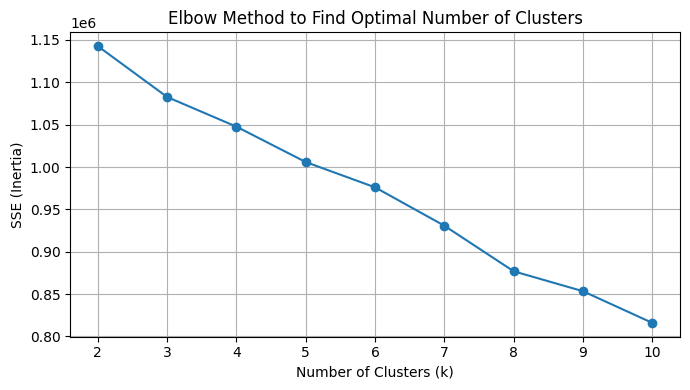

Silhouette Scores for each k:
Silhouette Score for k=2: 0.213
Silhouette Score for k=3: 0.136
Silhouette Score for k=4: 0.103
Silhouette Score for k=5: 0.126
Silhouette Score for k=6: 0.128
Silhouette Score for k=7: 0.143
Silhouette Score for k=8: 0.113
Silhouette Score for k=9: 0.140
Silhouette Score for k=10: 0.155


In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Trying multiple values of k to find the best number of clusters
sse = []  # Sum of Squared Errors
k_range = range(2, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    sse.append(km.inertia_)

#Elbow curve
plt.figure(figsize=(7, 4))
plt.plot(k_range, sse, marker='o')
plt.title("Elbow Method to Find Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE (Inertia)")
plt.xticks(k_range)
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.metrics import silhouette_score
print("Silhouette Scores for each k:")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score for k={k}: {score:.3f}")

#Visualization

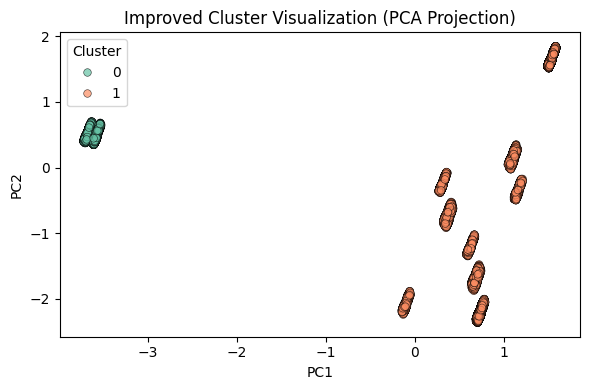

In [5]:
from sklearn.decomposition import PCA
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

adisease["Cluster"] = cluster_labels

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)


plt.figure(figsize=(6, 4))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette="Set2", edgecolor="k", s=30, alpha=0.7)
plt.title("Improved Cluster Visualization (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

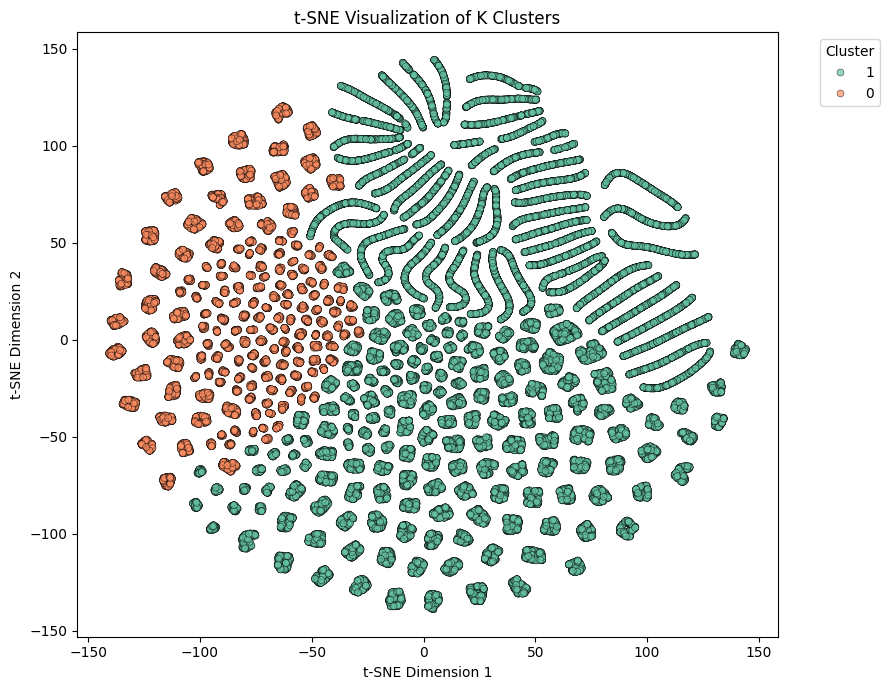

In [6]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_scaled)

plt.figure(figsize=(9, 7))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=adisease["Cluster"].astype(str), palette='Set2', edgecolor="k", s=25, alpha=0.7)
plt.title("t-SNE Visualization of K Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [7]:
# Frequency of animal types per cluster
print(adisease.groupby("Cluster")["Animal"].value_counts(normalize=True))

# Average age and temperature per cluster
print(adisease.groupby("Cluster")[["Age", "Temperature"]].mean())

# Most common symptoms per cluster
non_symptom_cols = ["Age", "Temperature"] + list(animal_dummies.columns) + ["Disease"]
symptom_cols = [col for col in traindata.columns if col not in non_symptom_cols]
c_symptoms = traindata[symptom_cols].copy()
c_symptoms["Cluster"] = adisease["Cluster"]
symptom_cluster = c_symptoms.groupby("Cluster").mean().round(2).T
print(symptom_cluster)

# Add Disease labels back to adisease for clarity (original labels)
adisease["Disease_Label"] = adisease["Disease"]
# Show disease distribution within each cluster (proportions)
disease_cluster_dist = adisease.groupby("Cluster")["Disease_Label"].value_counts(normalize=True).unstack().fillna(0)
print("Disease distribution per cluster (proportion):")
print(disease_cluster_dist.round(2))


Cluster  Animal 
0        buffalo    0.253912
         sheep      0.252693
         cow        0.249746
         goat       0.243650
1        cow        0.259194
         buffalo    0.257514
         goat       0.242515
         sheep      0.240777
Name: proportion, dtype: float64
              Age  Temperature
Cluster                       
0        6.733692   102.244737
1        6.779408   102.276798
Cluster                     0     1
blisters on gums         0.00  0.03
blisters on hooves       0.00  0.04
blisters on mouth        0.00  0.03
blisters on tongue       0.00  0.04
chest discomfort         0.50  0.00
chills                   0.49  0.00
crackling sound          0.00  0.17
depression               0.00  0.60
difficulty walking       0.00  0.23
fatigue                  0.51  0.00
lameness                 0.00  0.23
loss of appetite         0.00  0.89
painless lumps           0.00  0.43
shortness of breath      0.51  0.00
sores on gums            0.00  0.04
sores on hooves   

#Visualization

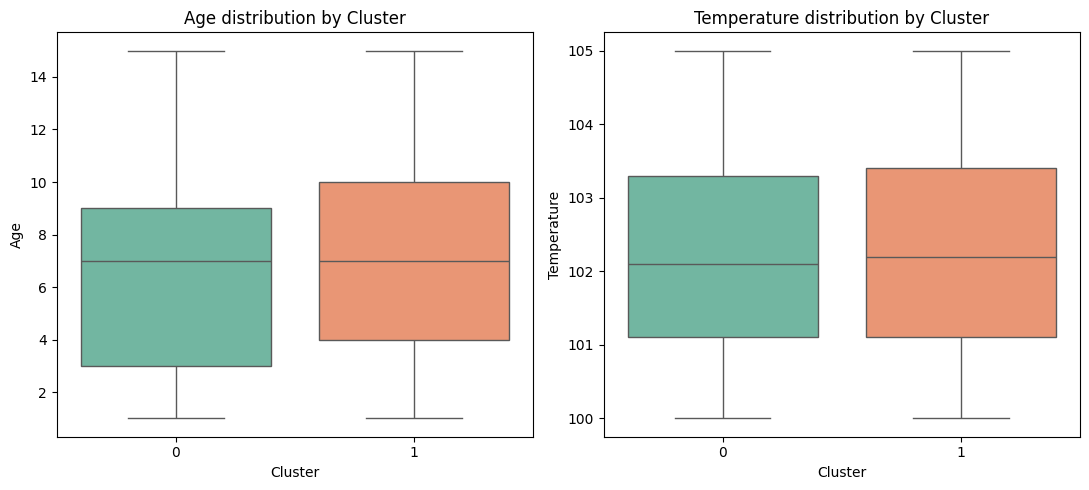

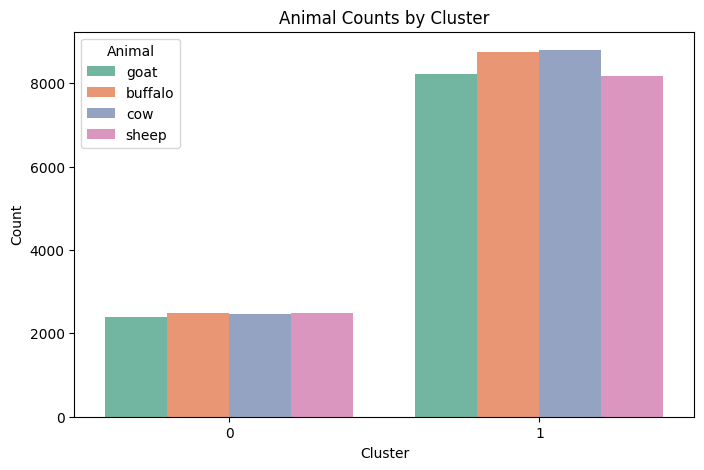

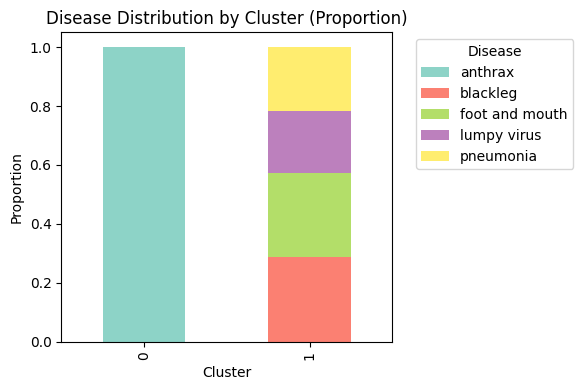

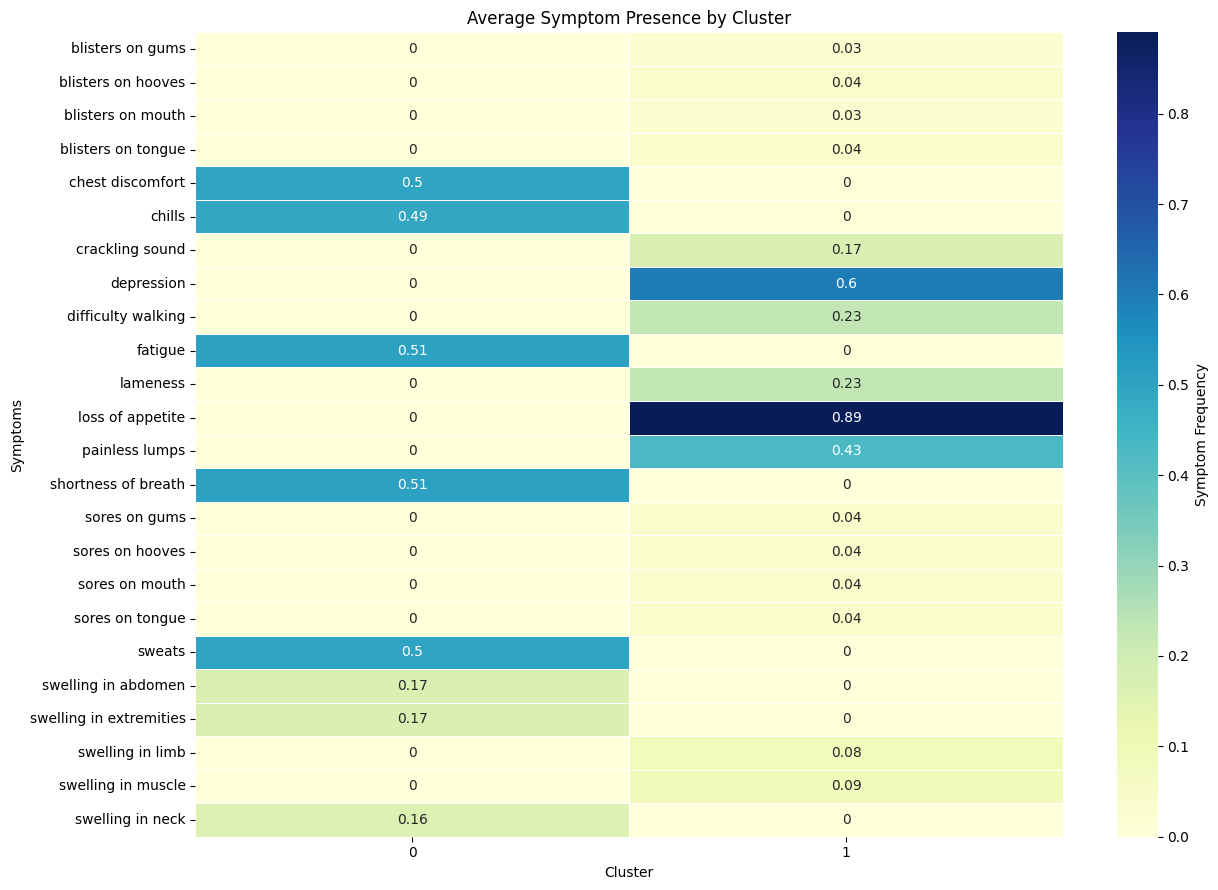

In [8]:
plt.figure(figsize=(11,5))
plt.subplot(1, 2, 1)
sns.boxplot(x="Cluster", y="Age", data=adisease, hue="Cluster", palette="Set2", legend=False)
plt.title("Age distribution by Cluster")
plt.subplot(1, 2, 2)
sns.boxplot(x="Cluster", y="Temperature", data=adisease, hue="Cluster", palette="Set2", legend=False)
plt.title("Temperature distribution by Cluster")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(data=adisease, x="Cluster", hue="Animal", palette="Set2")
plt.title("Animal Counts by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Animal")
plt.show()

disease_cluster_dist.plot(kind='bar', stacked=True, figsize=(6,4), colormap='Set3')
plt.title("Disease Distribution by Cluster (Proportion)")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.legend(title="Disease", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(13,9))
sns.heatmap(symptom_cluster, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Symptom Frequency'}, linewidths=0.5)
plt.title("Average Symptom Presence by Cluster")
plt.ylabel("Symptoms")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X_scaled, adisease["Cluster"])
print("Silhouette Score:", round(score, 3))

Silhouette Score: 0.213


Cluster           0    1
Disease                 
anthrax         1.0  0.0
blackleg        0.0  1.0
foot and mouth  0.0  1.0
lumpy virus     0.0  1.0
pneumonia       0.0  1.0


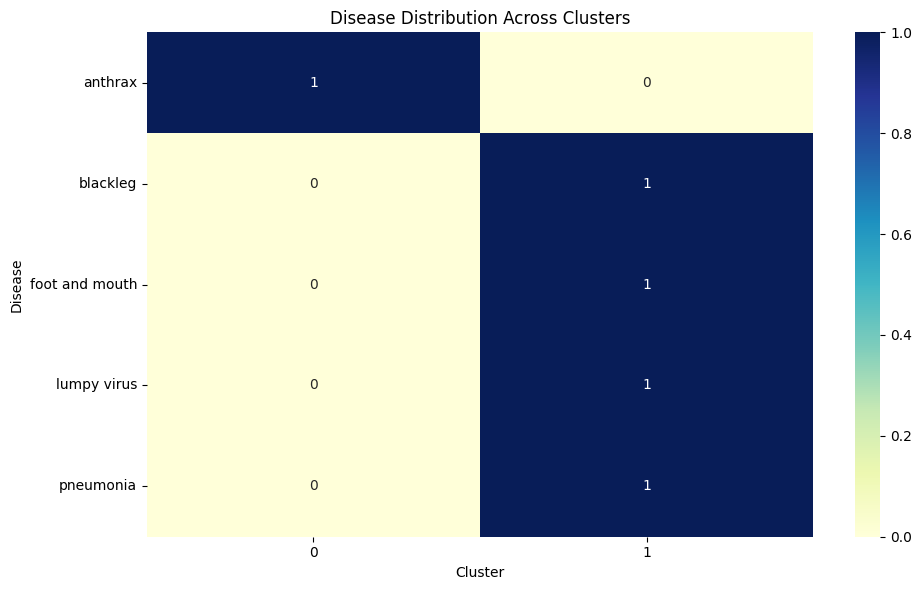

In [10]:
cluster_vs_disease = pd.crosstab(adisease["Disease"], adisease["Cluster"], normalize='index').round(2)
print(cluster_vs_disease)

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_vs_disease, annot=True, cmap="YlGnBu", cbar=True)
plt.title("Disease Distribution Across Clusters")
plt.ylabel("Disease")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()

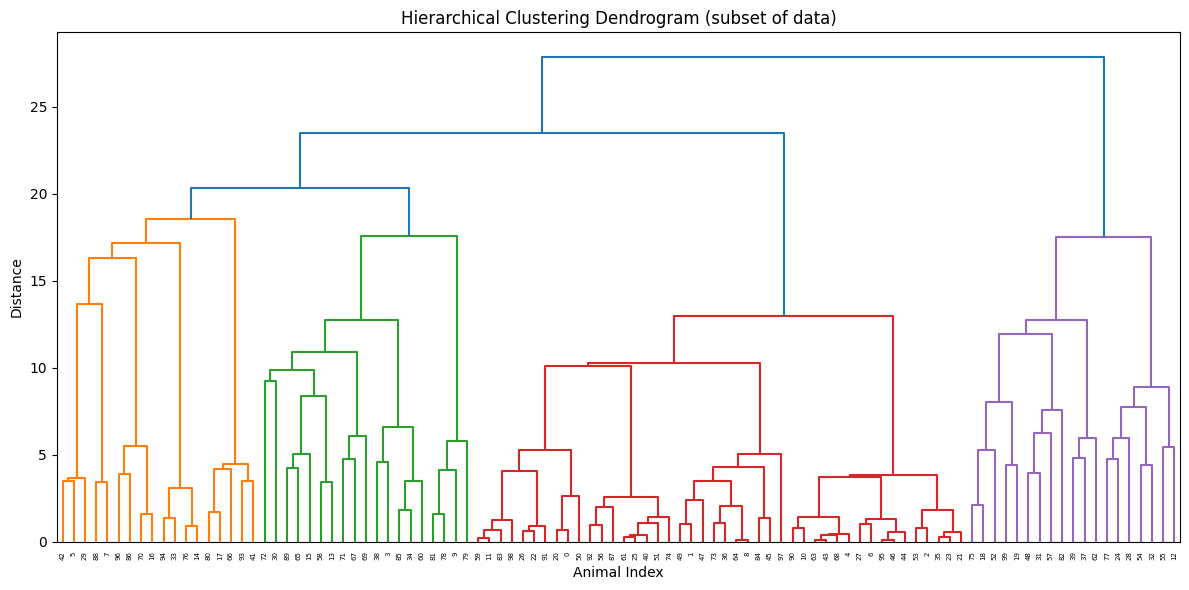

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Use subset for better performance (e.g., 100 rows)
X_sub = X_scaled[:100]
linked = linkage(X_sub, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title("Hierarchical Clustering Dendrogram (subset of data)")
plt.xlabel("Animal Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


#DBSCAN Clustering and No of Clusters Optimization

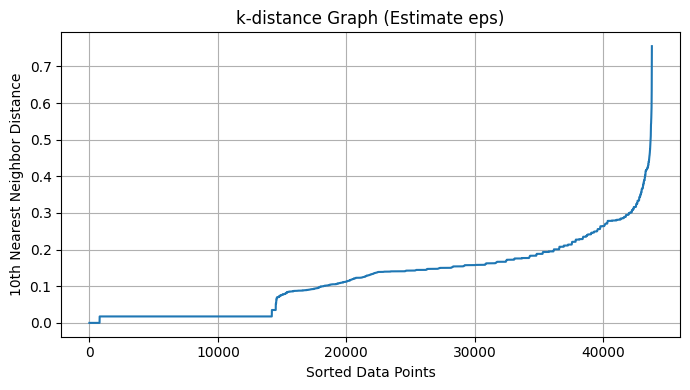

eps = 1.00, clusters = 128, silhouette = 0.671
eps = 1.30, clusters = 128, silhouette = 0.671
eps = 1.60, clusters = 96, silhouette = 0.669
eps = 1.90, clusters = 96, silhouette = 0.669
eps = 2.20, clusters = 38, silhouette = 0.519
eps = 2.50, clusters = 8, silhouette = 0.351
eps = 2.80, clusters = 6, silhouette = 0.302
eps = 3.10, clusters = 5, silhouette = 0.289
eps = 3.40, clusters = 3, silhouette = 0.307
eps = 3.70, clusters = 3, silhouette = 0.307
eps = 4.00, clusters = 3, silhouette = 0.307
eps = 4.30, clusters = 2, silhouette = 0.309
eps = 4.60, clusters = 2, silhouette = 0.309
eps = 4.90, clusters = 2, silhouette = 0.309


In [12]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_pca)          
distances, indices = neighbors_fit.kneighbors(X_pca)

k_distances = np.sort(distances[:, -1])       # last column = 10th neighbor
plt.figure(figsize=(7, 4))
plt.plot(k_distances)
plt.xlabel("Sorted Data Points")
plt.ylabel("10th Nearest Neighbor Distance")
plt.title("k-distance Graph (Estimate eps)")
plt.grid(True)
plt.tight_layout()
plt.show()

eps_values = np.arange(1.0, 5.0, 0.3)
for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=10).fit(X_pca)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    if n_clusters > 1:
        score = silhouette_score(X_pca, labels)
        print(f"eps = {eps:.2f}, clusters = {n_clusters}, silhouette = {score:.3f}")

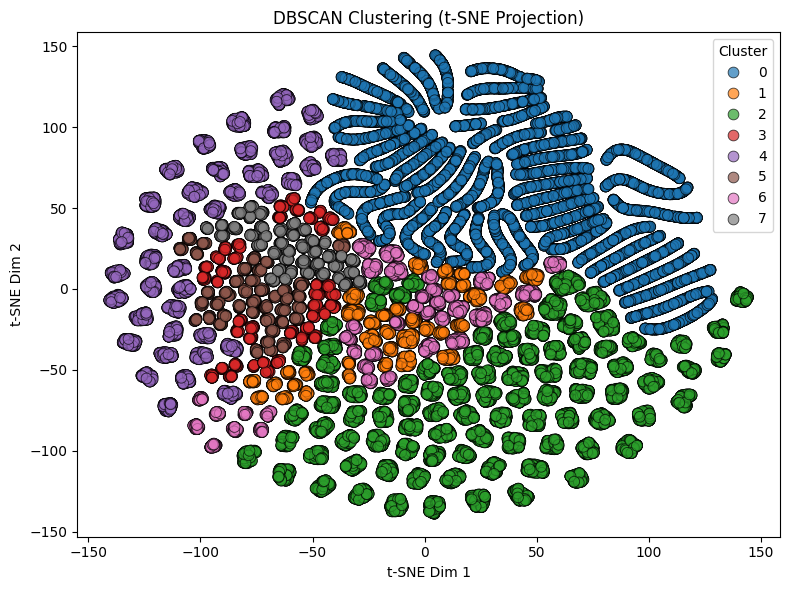

In [13]:

dbscan = DBSCAN(eps=2.5, min_samples=10) 
db_labels = dbscan.fit_predict(X_pca)

# Add DBSCAN labels to dataframe
adisease["DBSCAN_Cluster"] = db_labels

X_tsne_db = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne_db[:, 0], y=X_tsne_db[:, 1],
                hue=adisease["DBSCAN_Cluster"],
                palette="tab10", edgecolor='k', alpha=0.7, s=60)
plt.title("DBSCAN Clustering (t-SNE Projection)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [14]:
print(adisease["DBSCAN_Cluster"].value_counts())

print(adisease.groupby("DBSCAN_Cluster")[["Age", "Temperature"]].mean().round(2))

print(adisease.groupby("DBSCAN_Cluster")["Animal"].value_counts(normalize=True).round(2))

c_symptoms["DBSCAN_Cluster"] = adisease["DBSCAN_Cluster"]
print(c_symptoms.groupby("DBSCAN_Cluster")[symptom_cols].mean().T.round(2))

disease_cluster = adisease.groupby("DBSCAN_Cluster")["Disease_Label"].value_counts(normalize=True).unstack().fillna(0)
print("Disease distribution per DBSCAN cluster (proportion):")
print(disease_cluster.round(2))


DBSCAN_Cluster
0    14522
2    13630
4     4971
6     2985
1     2799
5     1680
3     1624
7     1567
Name: count, dtype: int64
                 Age  Temperature
DBSCAN_Cluster                   
0               6.84       102.32
1               6.78       102.26
2               6.73       102.23
3               6.74       102.21
4               6.70       102.25
5               6.84       102.27
6               6.69       102.29
7               6.74       102.24
DBSCAN_Cluster  Animal 
0               buffalo    0.27
                cow        0.27
                sheep      0.23
                goat       0.23
1               cow        0.26
                sheep      0.25
                goat       0.24
                buffalo    0.24
2               cow        0.25
                buffalo    0.25
                goat       0.25
                sheep      0.25
3               sheep      0.26
                cow        0.25
                goat       0.25
                buffalo    

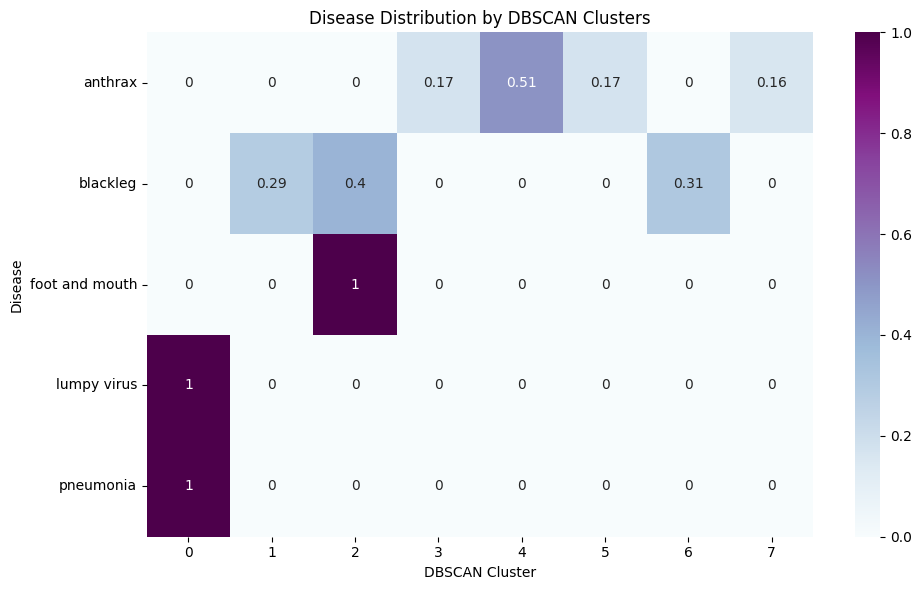

In [15]:
dbscan_vs_disease = pd.crosstab(adisease["Disease"], adisease["DBSCAN_Cluster"], normalize='index').round(2)
plt.figure(figsize=(10, 6))
sns.heatmap(dbscan_vs_disease, annot=True, cmap="BuPu")
plt.title("Disease Distribution by DBSCAN Clusters")
plt.xlabel("DBSCAN Cluster")
plt.ylabel("Disease")
plt.tight_layout()
plt.show() 

c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[2.75179054e-15 1.30937056e-06 2.63960037e-06 8.59137956e-06]
not reaching the requested tolerance 6.064772605895996e-06.
Use iteration 2000 instead with accuracy 
2.746434812927664e-06.

  _, diffusion_map = lobpcg(
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[3.29491167e-15 1.30976469e-06 2.61744514e-06 7.05852969e-06]
not reaching the requested tolerance 6.064772605895996e-06.
  _, diffusion_map = lobpcg(


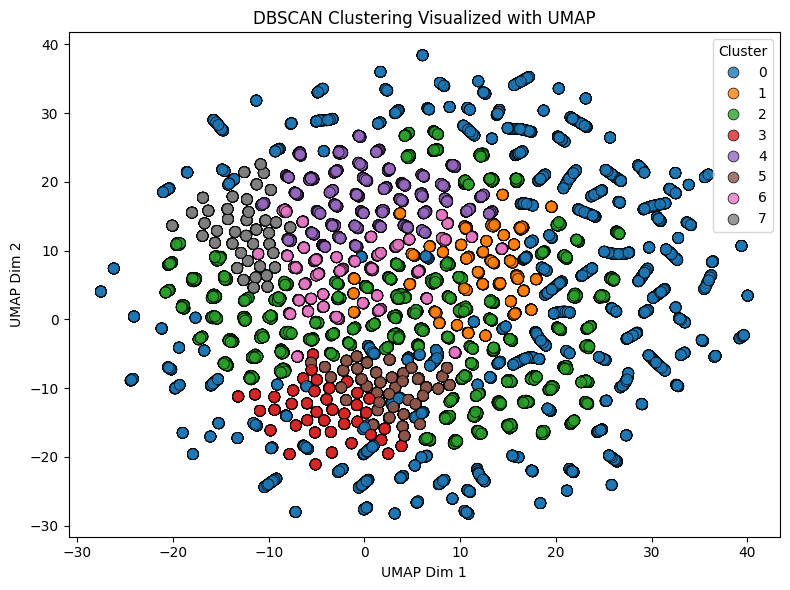

In [17]:
import umap.umap_ as umap

umap_model = umap.UMAP(n_components=2, random_state=42, n_epochs=1000)
X_umap = umap_model.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=adisease["DBSCAN_Cluster"],
                palette="tab10", s=60, alpha=0.8, edgecolor="k")
plt.title("DBSCAN Clustering Visualized with UMAP")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()